ASTR241 Exoplanets Homework Code, Spring 2023
Replicate published exoplanet search plots 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
import scipy.optimize

In [3]:
def plot_pretty():
    plt.rcParams['figure.dpi']= 300
    plt.rc('savefig', dpi=300)
    plt.rc('font', size=18)
    plt.rc('axes',labelsize=18,titlesize=16)
    plt.rc('xtick', direction='out',labelsize=16) 
    plt.rc('ytick', direction='out',labelsize=16)
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    plt.rc('figure', titlesize=18)
    plt.tick_params(which='major',length=6, width=1.5,labelsize=16)
    plt.minorticks_on()
    plt.tick_params(which='minor',length=3,width=1)


In [8]:
# confirmed
p1 = 'PS_2023.04.25_13.43.59.csv'
# candidates
p2 = 'cumulative_2023.04.25_13.45.18.csv'
# stars
s = 'keplerstellar_2023.04.24_18.24.15.csv'

pf1 = pd.read_csv(p1,comment='#')
pf2 = pd.read_csv(p2,comment='#')
sf = pd.read_csv(s,comment='#')

25426.4


In [257]:
# Splice together some inconsistent CSVs

# pf1: pl_name pl_orbper pl_orbperr1 pl_orbperr2 pl_rade pl_radeerr1 pl_radeerr2 st_teff st_rad st_mass st_logg sy_kepmag
# pf2: kepoi_name koi_period koi_period_err1 koi_period_err2 koi_prad koi_prad_err1 koi_prad_err2 koi_steff koi_srad koi_smass koi_slogg koi_kepmag
columns = ['name', 'P', 'Perrupper', 'Perrlower', 'planetR','planetRerrupper','planetRerrlower','teff','starR','starM','logg','kepmag','a','a/R']
pf = pd.DataFrame()
pf[columns[0]] = pf1['pl_name'].append(pf2['kepoi_name'])
pf[columns[1]] = pf1['pl_orbper'].append(pf2['koi_period'])
pf[columns[2]] = pf1['pl_orbpererr1'].append(pf2['koi_period_err1'])
pf[columns[3]] = pf1['pl_orbpererr2'].append(pf2['koi_period_err2'])
pf[columns[4]] = pf1['pl_rade'].append(pf2['koi_prad'])
pf[columns[5]] = pf1['pl_radeerr1'].append(pf2['koi_prad_err1'])
pf[columns[6]] = pf1['pl_radeerr2'].append(pf2['koi_prad_err2'])
pf[columns[7]] = pf1['st_teff'].append(pf2['koi_steff'])
pf[columns[8]] = pf1['st_rad'].append(pf2['koi_srad'])
pf[columns[9]] = pf1['st_mass'].append(pf2['koi_smass'])
pf[columns[10]] = pf1['st_logg'].append(pf2['koi_slogg'])
pf[columns[11]] = pf1['sy_kepmag'].append(pf2['koi_kepmag'])
pf[columns[12]] = pf1['pl_orbsmax'].append(pf2['koi_sma'])
pf[columns[13]] = pf1['pl_ratdor'].append(pf2['koi_dor'])


pf = pf[(pf['teff']> 4100) & (pf['teff'] < 6100)]
pf = pf[(pf['logg']> 4.0) & (pf['logg'] < 4.9)]
pf = pf[(pf['kepmag'] < 15)]
pf = pf[(pf['P']< 50)]

sf = sf[(sf['teff']> 4100) & (sf['teff'] < 6100)]
sf = sf[(sf['logg']> 4.0) & (sf['logg'] < 4.9)]
sf = sf[(sf['kepmag'] < 15)]
sn = len(sf)

nulls = pf['a/R'].isnull()
pf.loc[nulls,'a/R']= pf.loc[nulls,'a'] / pf.loc[nulls,'starR']
pf = pf.dropna(subset=['a','starR','a/R'])

print(np.min(pf['a']))

0.00716


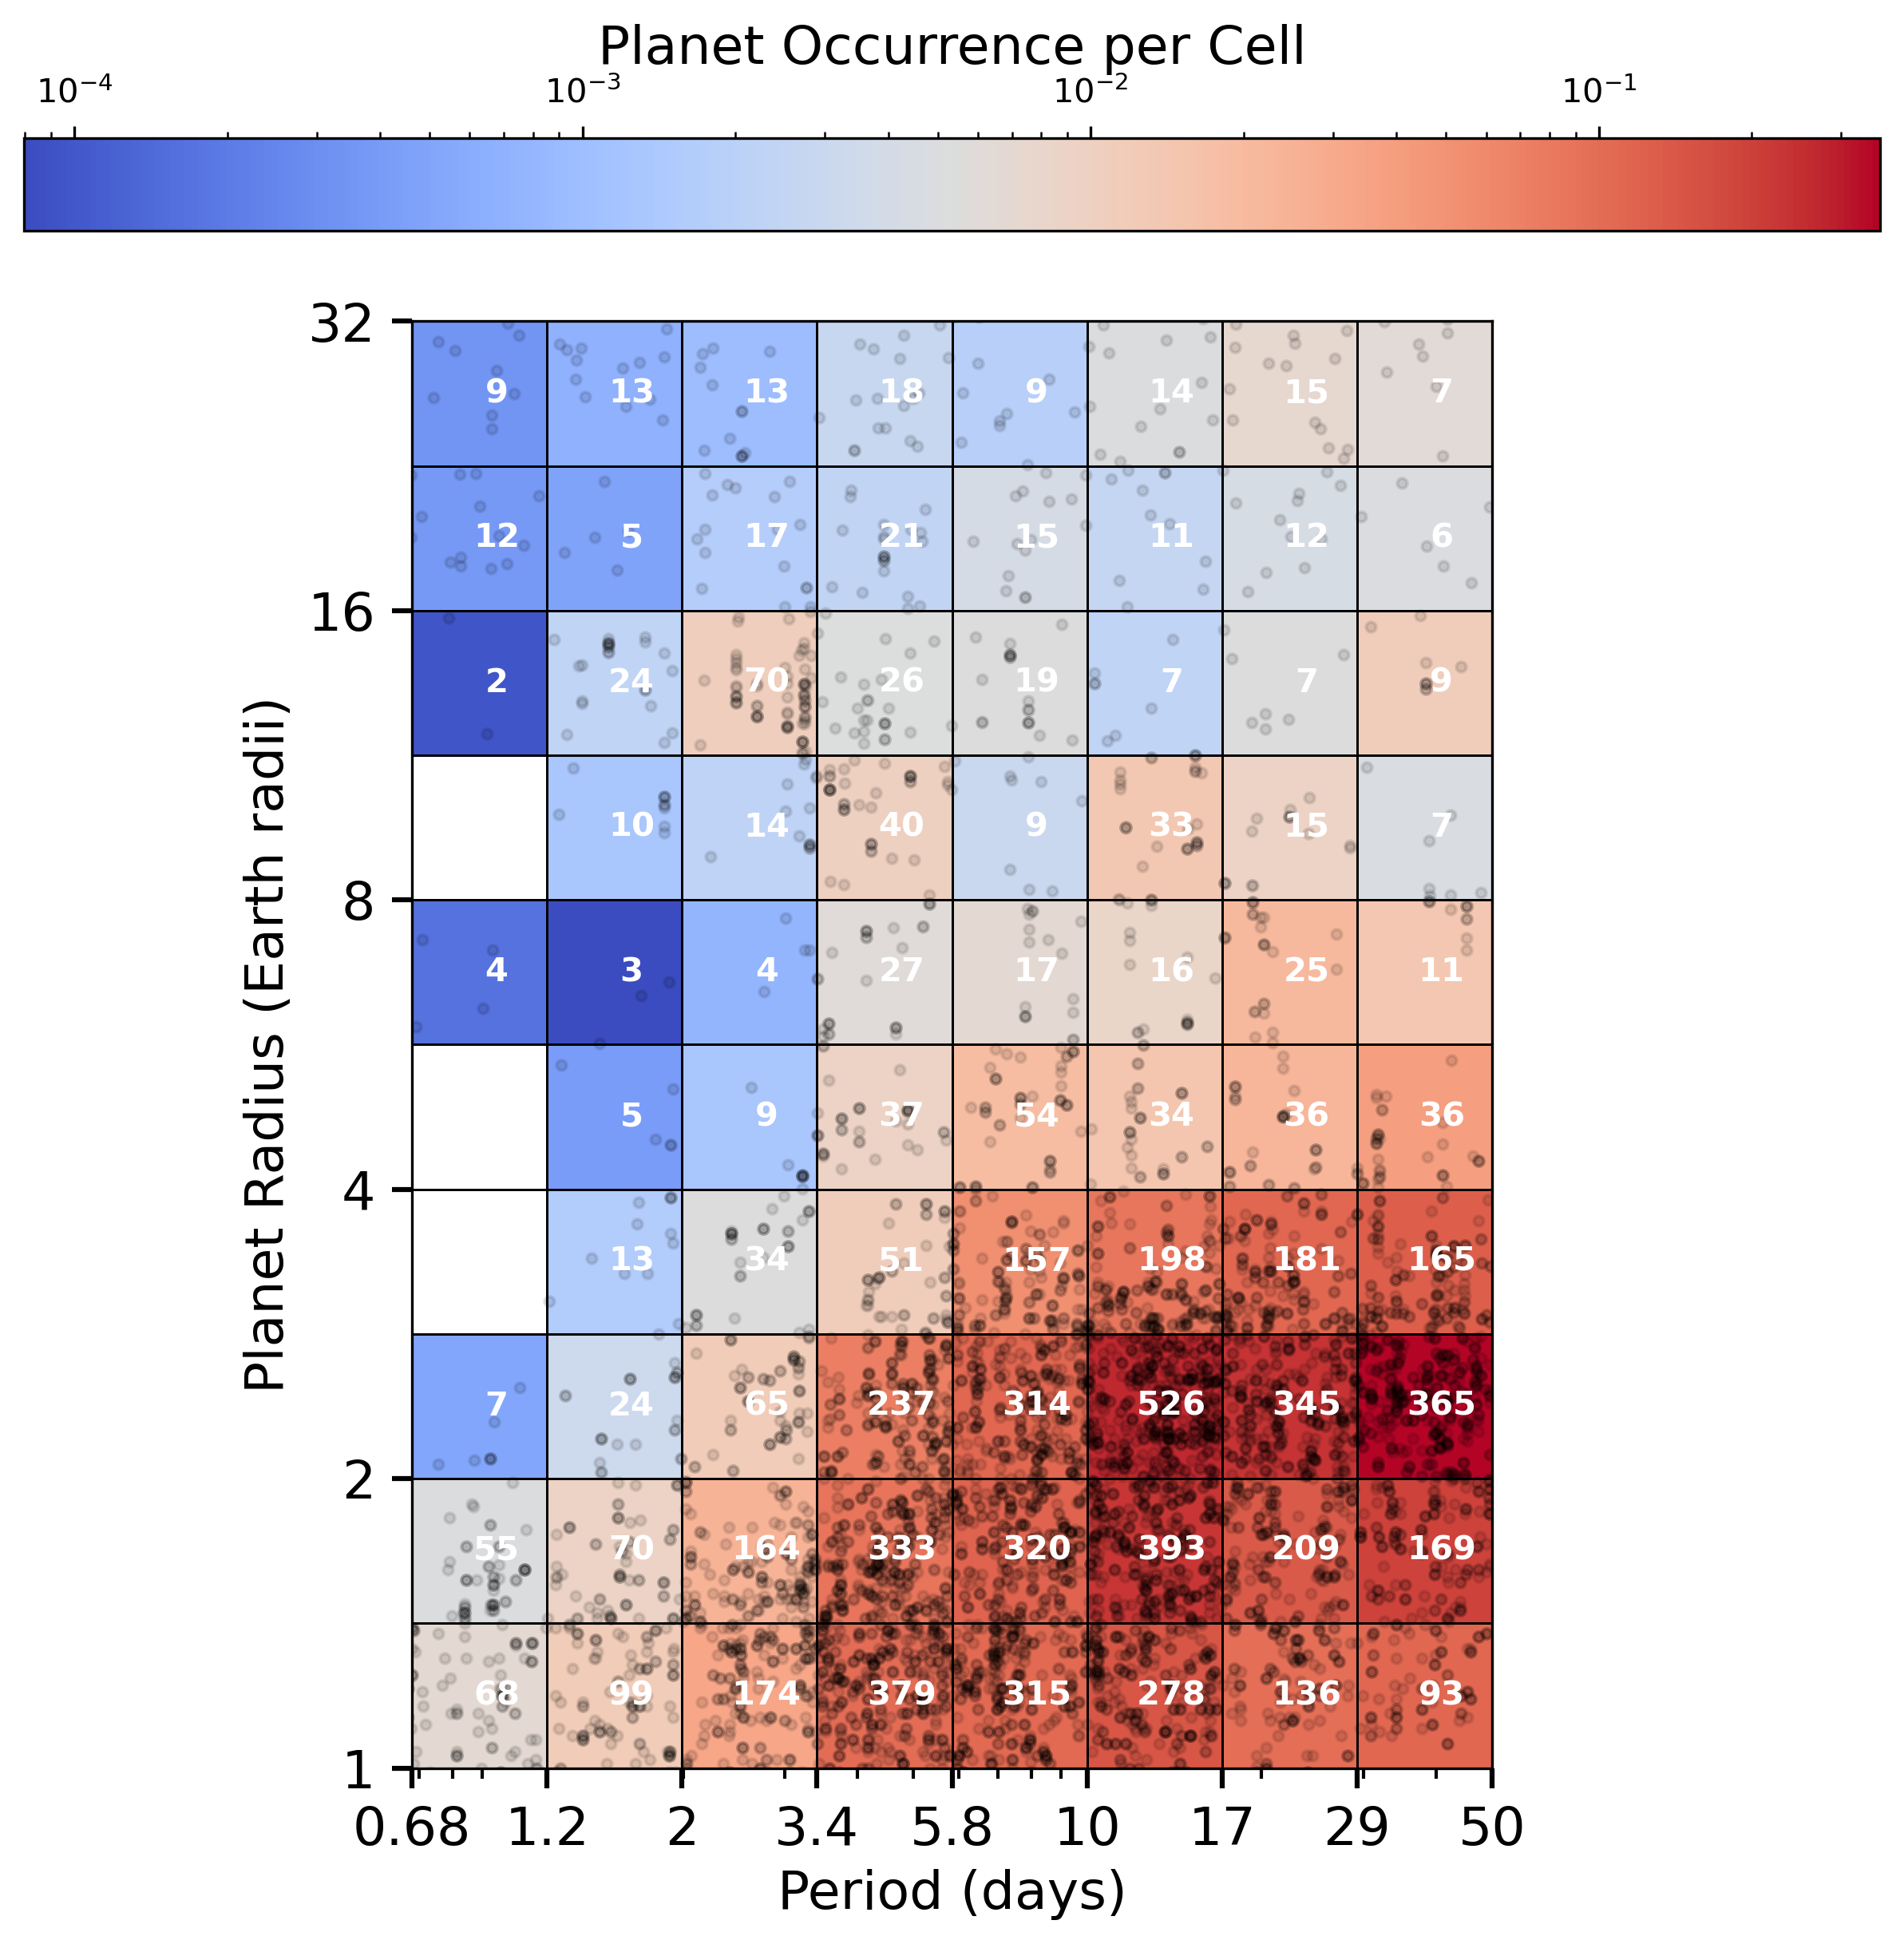

In [135]:
xp = np.logspace(np.log10(0.68),np.log10(50),9,base=10)
yr = np.logspace(0,5,11,base=2)
weights = pf['a/R'] / sn
hist, _, _ = np.histogram2d(pf['P'],pf['planetR'],bins=(xp,yr))
counts, xedge, yedge = np.histogram2d(pf['P'],pf['planetR'],bins=(xp,yr),weights=weights)

def fig4():
    fig, ax = plt.subplots(figsize=(10,10))
    plot_pretty()

    pcm = ax.pcolormesh(xedge,yedge,counts.T,cmap='coolwarm',norm=colors.LogNorm(),ec='k',lw=0.25)
    ax.scatter(pf['P'],pf['planetR'],c='k',alpha=0.10,marker='.')

    ax.set_xscale('log',base=10)
    ax.set_yscale('log',base=2)

    ax.set_xticks(xp)
    ax.set_xticklabels(['0.68','1.2','2','3.4','5.8','10','17','29','50'])
    ax.set_yticks(yr[::2])
    ax.set_yticklabels(['1','2','4','8','16','32'])
    ax.set_aspect(0.5)
    ax.set_xlim(0.68,50)
    ax.set_ylim(1,32)
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('Planet Radius (Earth radii)')

    cbar = plt.colorbar(pcm,location='top',label='Planet Occurrence per Cell')
    cbar.ax.tick_params(labelsize=10)

    for i in range(10):
        for j in range(8):
            ax.text(xedge[j]+0.4*xedge[j],yedge[i]*(2**0.25), '{:0.0f}'.format(hist.T[i,j]),
            color="w", ha="center", va="center", fontweight="bold",fontsize=10)


    plt.show()

fig4()

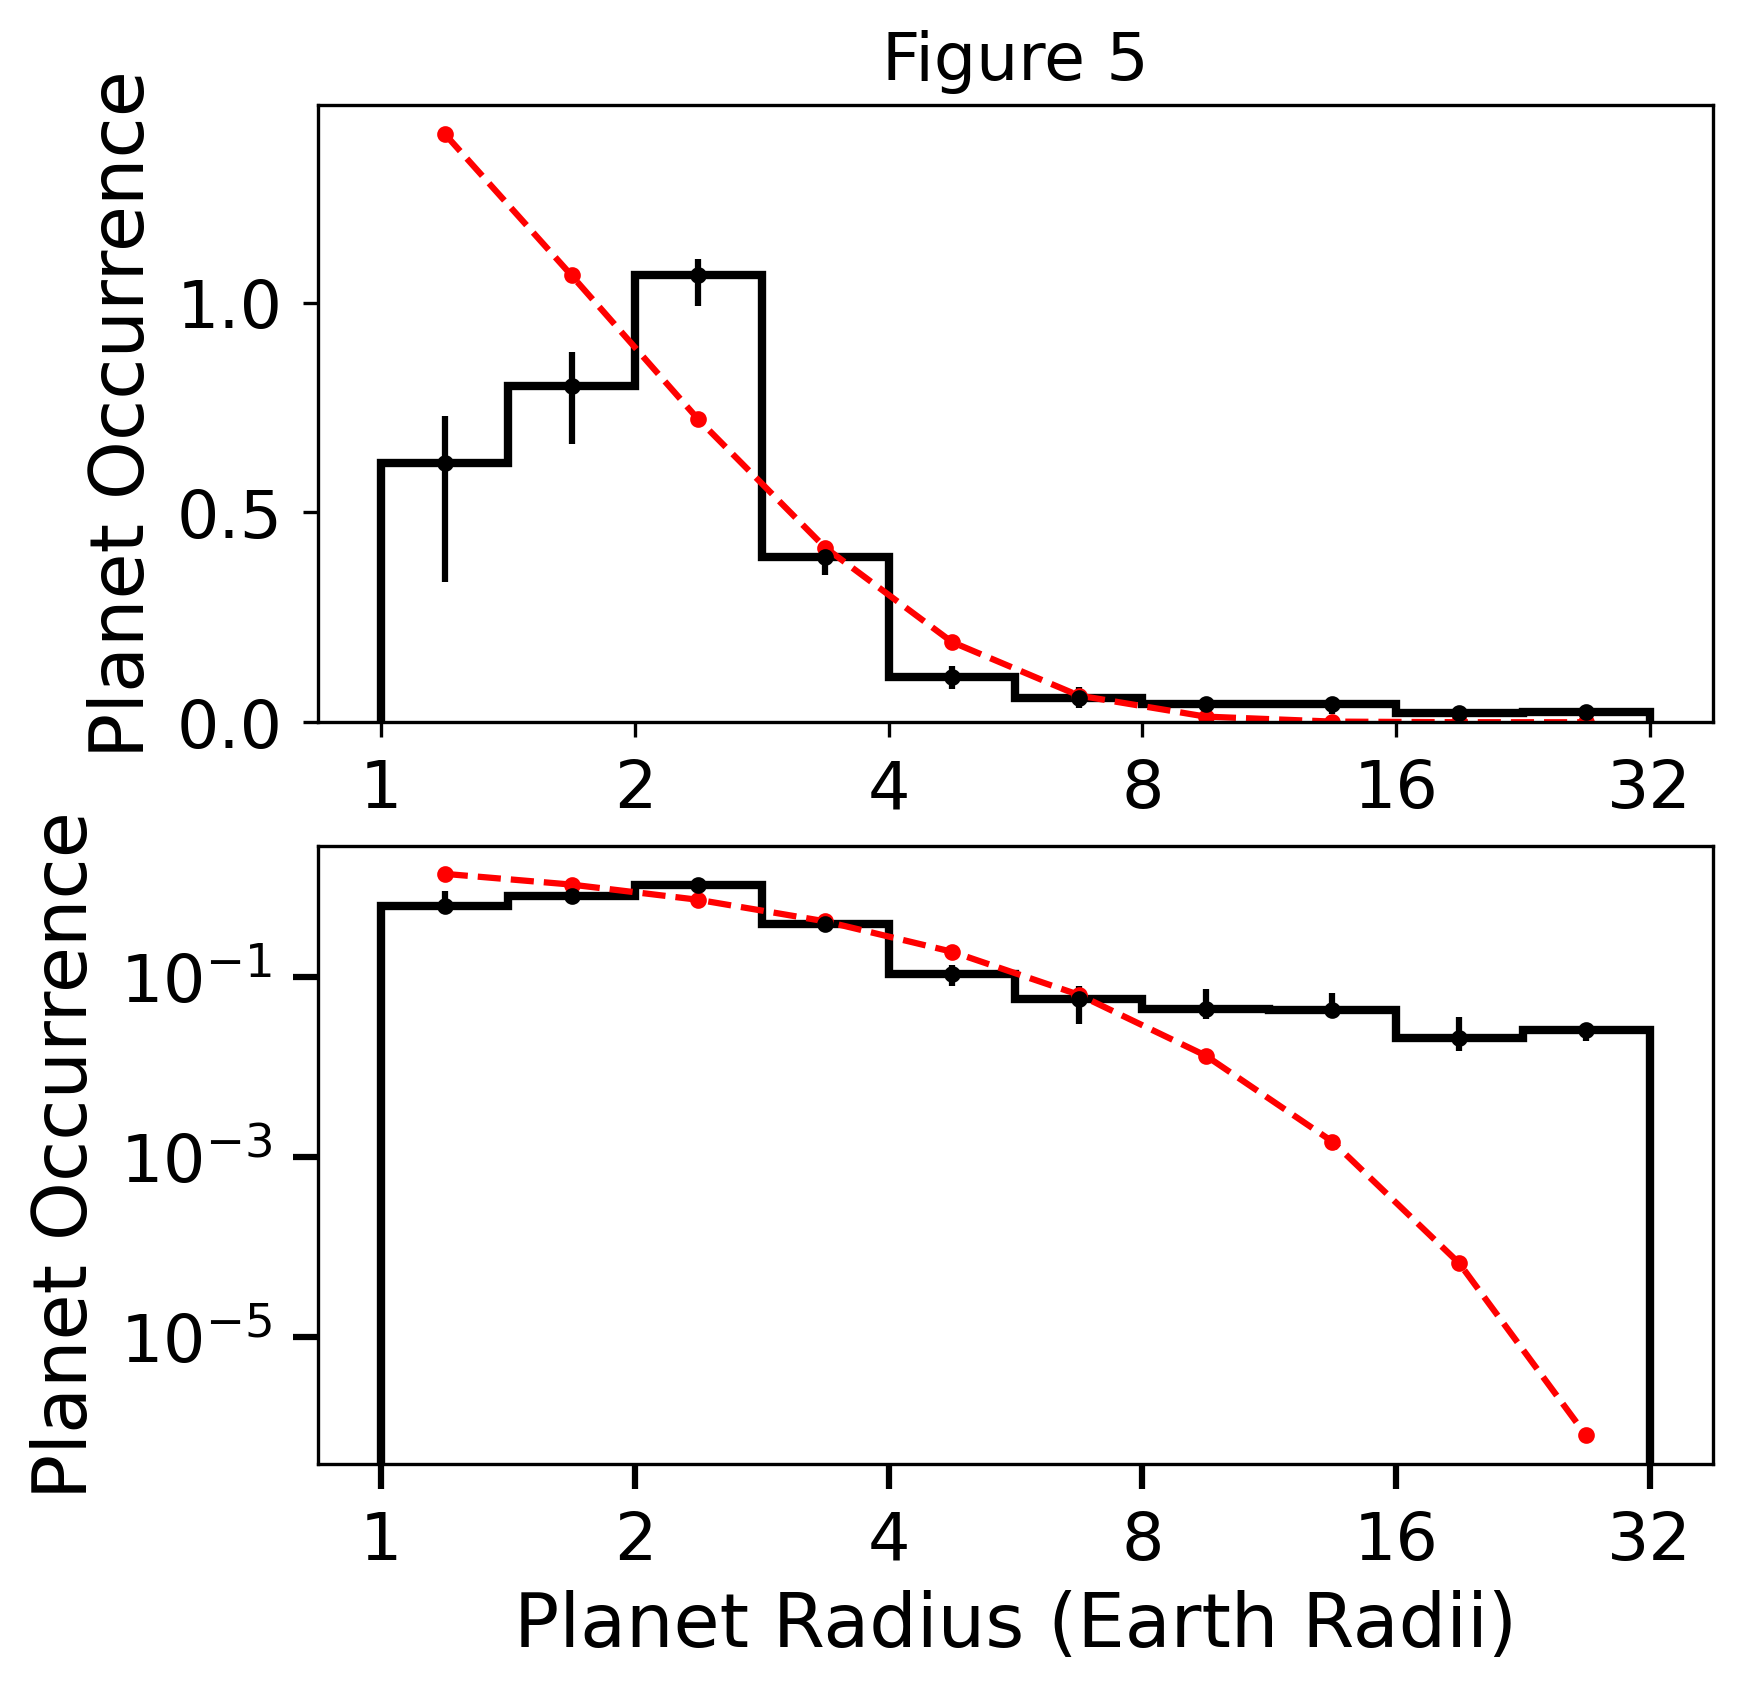

In [140]:
# Fig 5: # planets per star with P < 50 vs planetR (hist with line fit, linear and log y)
rad_counts = np.sum(counts,axis=0)

def fig5():
    fig, ax = plt.subplots(2,1,figsize=(6,6))
    plot_pretty()
    x = yedge[:-1]*(2**0.25)

    ax[0].set_xscale('log',base=2)
    ax[0].set_xticks(yr[::2])
    ax[0].set_xticklabels(['1','2','4','8','16','32'])
    ax[0].tick_params(labelsize=16)
    ax[0].set_ylabel('Planet Occurrence')
    ax[0].set_title('Figure 5')

    r,_, _ = ax[0].hist(pf['planetR'],bins=yr,weights=weights,histtype='step',lw=2,ec='k')
    r_upper, _ = np.histogram(pf['planetRerrupper'],bins=yr,weights=weights)
    r_lower, _ = np.histogram(-1*pf['planetRerrlower'],bins=yr,weights=weights)
    ax[0].errorbar(x,r,yerr=(r_upper,r_lower),color='k',fmt='.')
    params, cov = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),x,r,sigma=(r_lower + r_upper))
    ax[0].plot(x, params[0]*np.exp(params[1]*x),'.--',color='r')

    ax[1].set_xscale('log',base=2)
    ax[1].set_xticks(yr[::2])
    ax[1].set_xticklabels(['1','2','4','8','16','32'])
    ax[1].set_yscale('log',base=10)
    ax[1].set_xlabel('Planet Radius (Earth Radii)')
    ax[1].set_ylabel('Planet Occurrence')
    r,_, _ = ax[1].hist(pf['planetR'],bins=yr,weights=weights,histtype='step',lw=2,ec='k')
    ax[1].errorbar(x,r,yerr=(r_lower,r_upper),color='k',fmt='.')
    ax[1].plot(x, params[0]*np.exp(params[1]*x),'.--',color='r')

    
    plt.show()

fig5()   

2.76


(array([0.00050829, 0.00496576, 0.0175421 , 0.08109728, 0.16165686,
        0.35600269, 0.34578127, 0.47494879]),
 array([0.00016864, 0.00048343, 0.00201593, 0.01509601, 0.02521516,
        0.02294718, 0.04392738, 0.05382555]),
 array([0.00082006, 0.00475586, 0.01587401, 0.02074349, 0.014474  ,
        0.0220473 , 0.02618559, 0.02691948]))

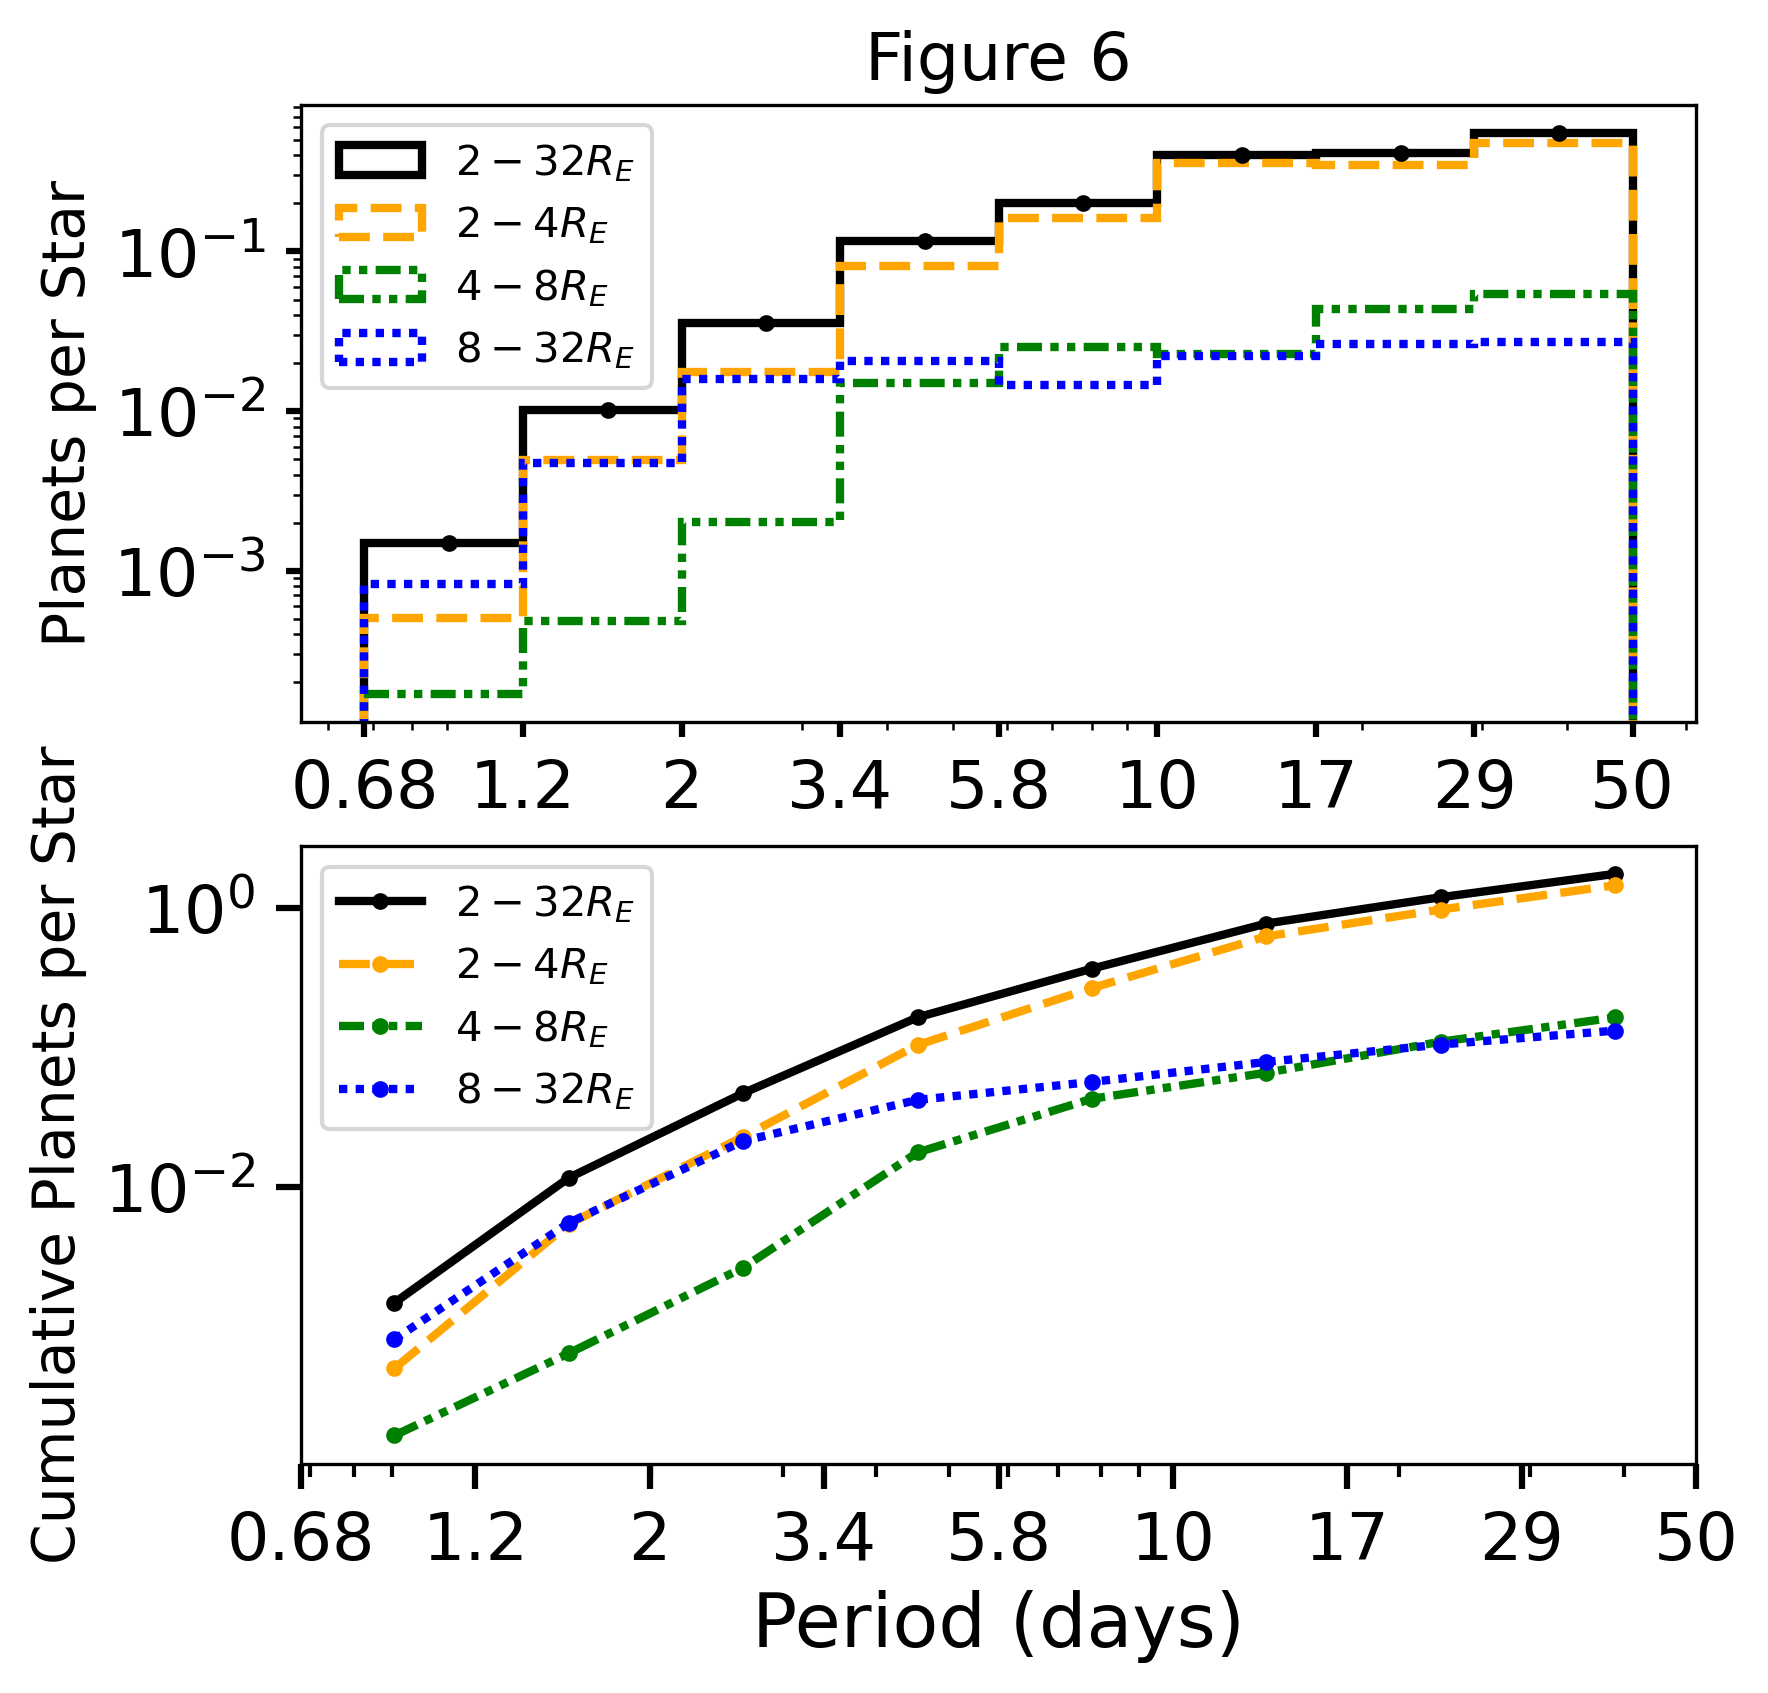

In [243]:
# Fig 6: # planets per star hist and cumulative planets per star line vs P (y log)
def fig6():
    fig, ax = plt.subplots(2,1,figsize=(6,6))
    plot_pretty()

    x = xedge[:-1]*(10**0.125)
    yticks = np.logspace(-1.5,0,5,base=10)

    ax[0].set_xscale('log',base=10)
    ax[0].set_yscale('log',base=10)
    ax[0].set_xticks(xp)
    ax[0].set_xticklabels(['0.68','1.2','2','3.4','5.8','10','17','29','50'])
    ax[0].xaxis.set_tick_params(width=1.5)
    ax[0].yaxis.set_tick_params(width=1.5)
    ax[0].tick_params(labelsize=16)
    ax[0].set_ylabel('Planets per Star',fontsize=14)
    ax[0].set_title('Figure 6')

    index1 = ((pf['planetR']>2 ) & (pf['planetR']<32))
    index2 = ((pf['planetR']>2 ) & (pf['planetR']<4))
    index3 = ((pf['planetR']>4 ) & (pf['planetR']<8))
    index4 = ((pf['planetR']>8 ) & (pf['planetR']<32))
    
    print(np.median(pf.loc[index1,'planetR']))
    r,_, _ = ax[0].hist(pf.loc[index1,'P'],bins=xp,weights=weights[index1],histtype='step',lw=2,ec='k',label=r'$2-32R_E$')
    r2,_,_ = ax[0].hist(pf.loc[index2,'P'],bins=xp,weights=weights[index2],histtype='step',lw=2,ec='orange',label=r'$2-4R_E$',ls='--')
    r3,_,_ = ax[0].hist(pf.loc[index3,'P'],bins=xp,weights=weights[index3],histtype='step',lw=2,ec='g',label=r'$4-8R_E$',ls=(0,(3,1,1,1,1,1)))
    r4,_,_ = ax[0].hist(pf.loc[index4,'P'],bins=xp,weights=weights[index4],histtype='step',lw=2,ec='b',label=r'$8-32R_E$',ls=(0,(1,1)))

    ax[0].scatter(x,r,c='k',marker='.',zorder=10)
    ax[0].legend(fontsize=10)

    c1 = [r[0],np.sum(r[0:2]),np.sum(r[0:3]),np.sum(r[0:4]),np.sum(r[0:5]),np.sum(r[0:6]),np.sum(r[0:7]),np.sum(r)]
    c2 = [r2[0],np.sum(r2[0:2]),np.sum(r2[0:3]),np.sum(r2[0:4]),np.sum(r2[0:5]),np.sum(r2[0:6]),np.sum(r2[0:7]),np.sum(r2)]
    c3 = [r3[0],np.sum(r3[0:2]),np.sum(r3[0:3]),np.sum(r3[0:4]),np.sum(r3[0:5]),np.sum(r3[0:6]),np.sum(r3[0:7]),np.sum(r3)]
    c4 = [r4[0],np.sum(r4[0:2]),np.sum(r4[0:3]),np.sum(r4[0:4]),np.sum(r4[0:5]),np.sum(r4[0:6]),np.sum(r4[0:7]),np.sum(r4)]

    ax[1].set_xscale('log',base=10)
    ax[1].set_xticks(xp)
    ax[1].set_xticklabels(['0.68','1.2','2','3.4','5.8','10','17','29','50'])
    ax[1].set_xlim(0.68,50)
    ax[1].set_yscale('log',base=10)
    ax[1].set_xlabel('Period (days)')
    ax[1].set_ylabel('Cumulative Planets per Star',fontsize=14)

    ax[1].plot(x,c1,lw=2,c='k',label=r'$2-32R_E$',marker='.')
    ax[1].plot(x,c2,lw=2,c='orange',label=r'$2-4R_E$',ls='--',marker='.')
    ax[1].plot(x,c3,lw=2,c='g',label=r'$4-8R_E$',ls=(0,(3,1,1,1,1,1)),marker='.')
    ax[1].plot(x,c4,lw=2,c='b',label=r'$8-32R_E$',ls=(0,(1,1)),marker='.')    
    ax[1].legend(fontsize=10)
    return r2,r3,r4

    plt.show()
fig6()   

In [229]:
def func(x,k,a,b,g):
    return k*(x**(a))*(1-np.exp((x/b)**g))

def func2(x,a,b,c):
    return a*np.exp(-b*x) + c

2.76
[-0.55388909  0.07345361  0.49554186] [-0.06420569  0.05500271  0.06097888] [-0.03451076  0.46347914  0.02332422]


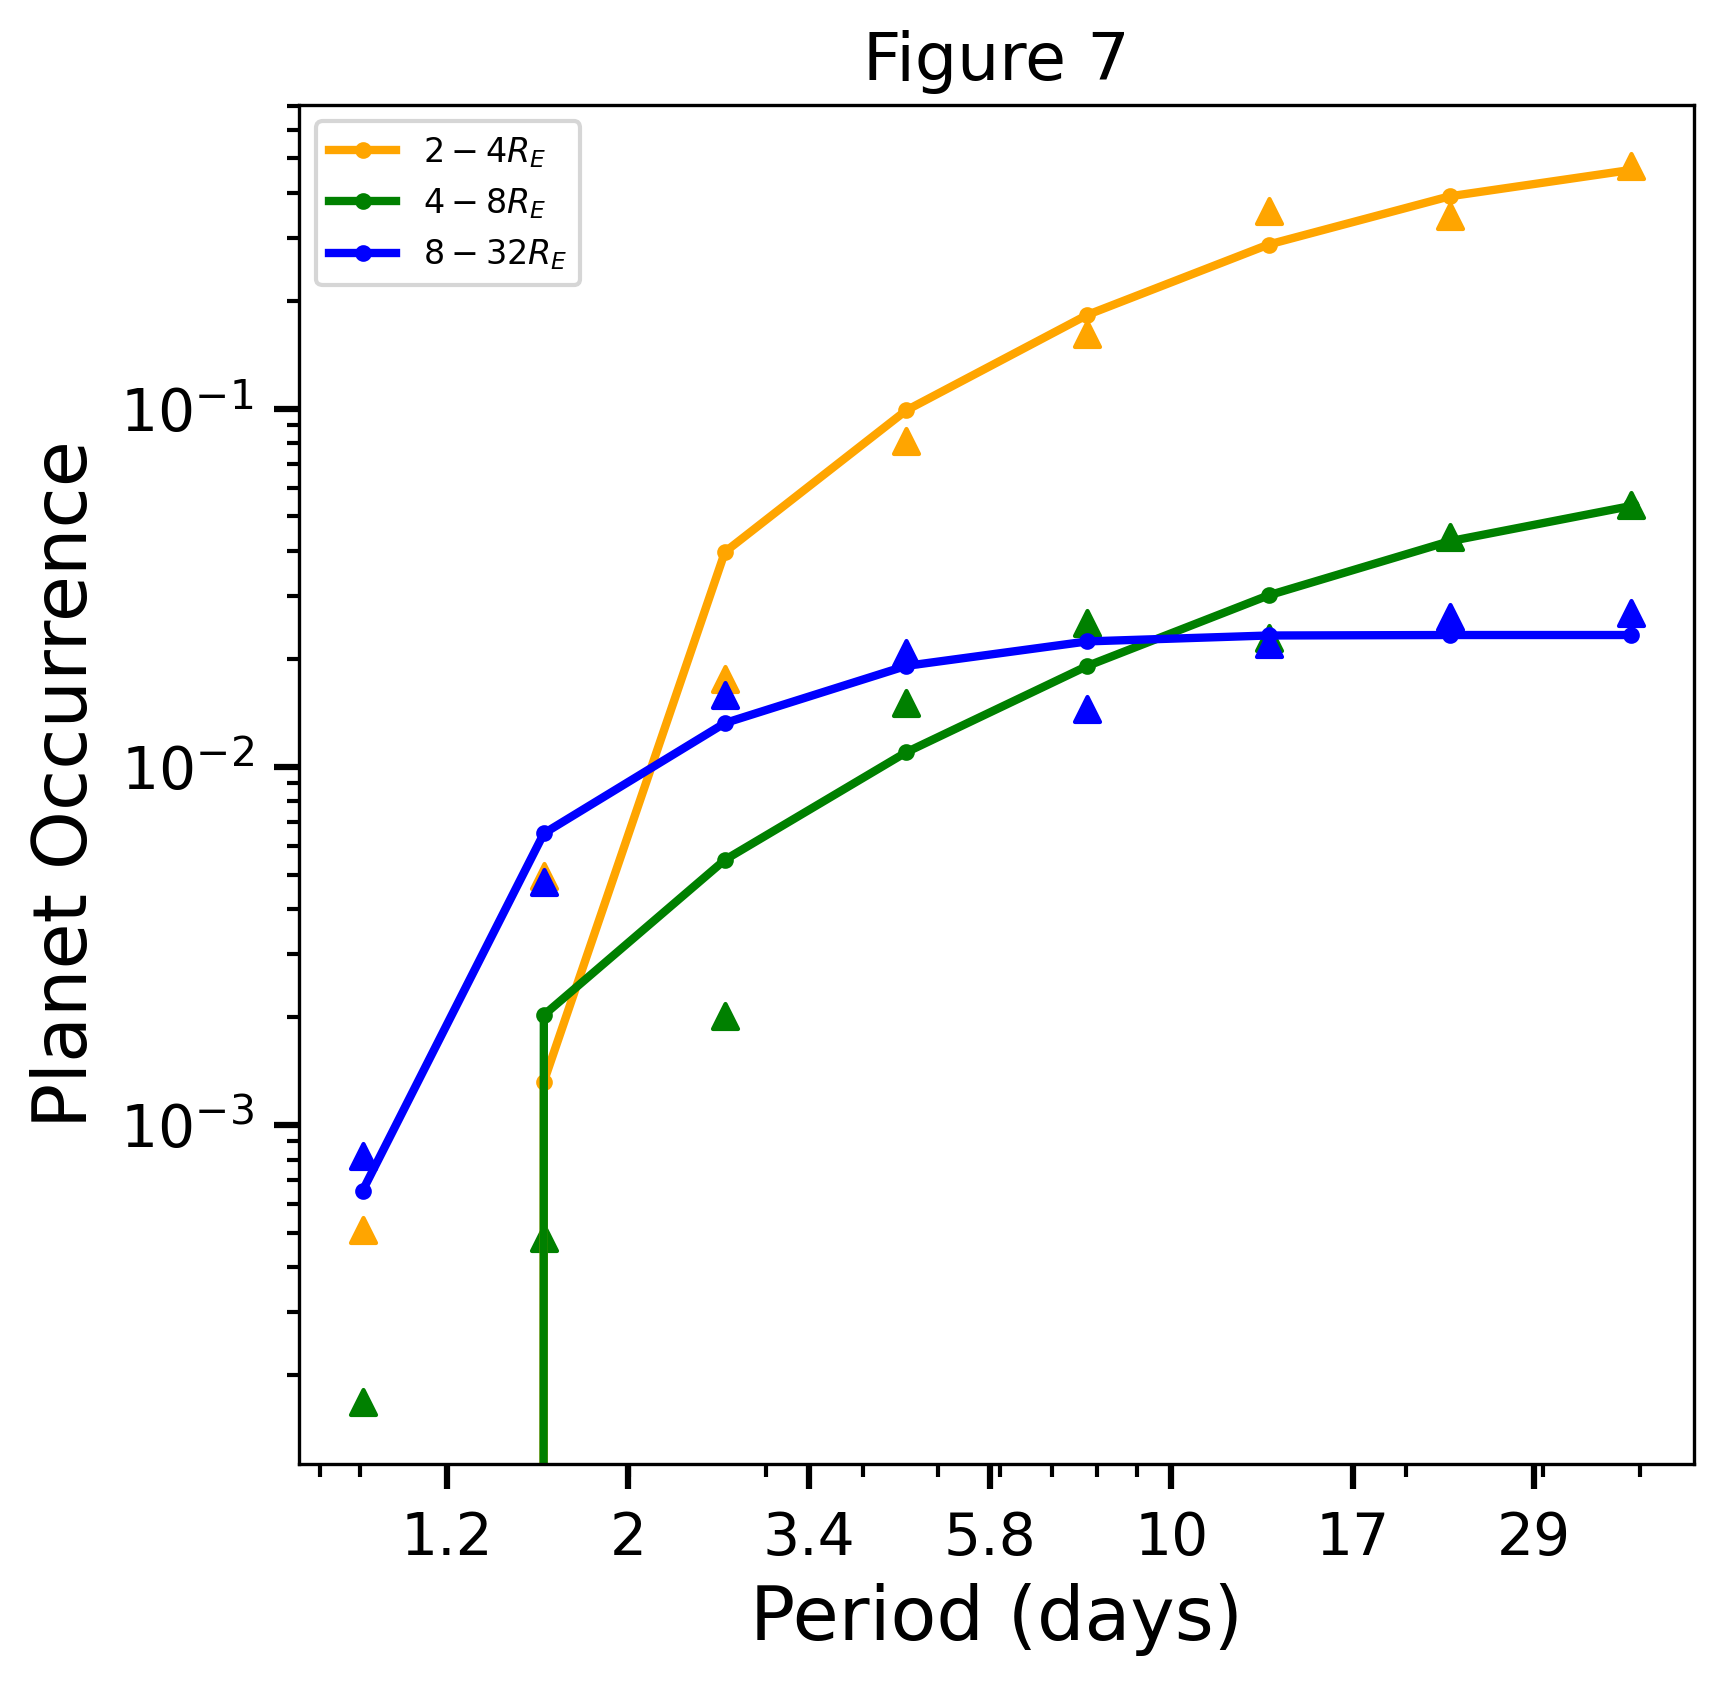

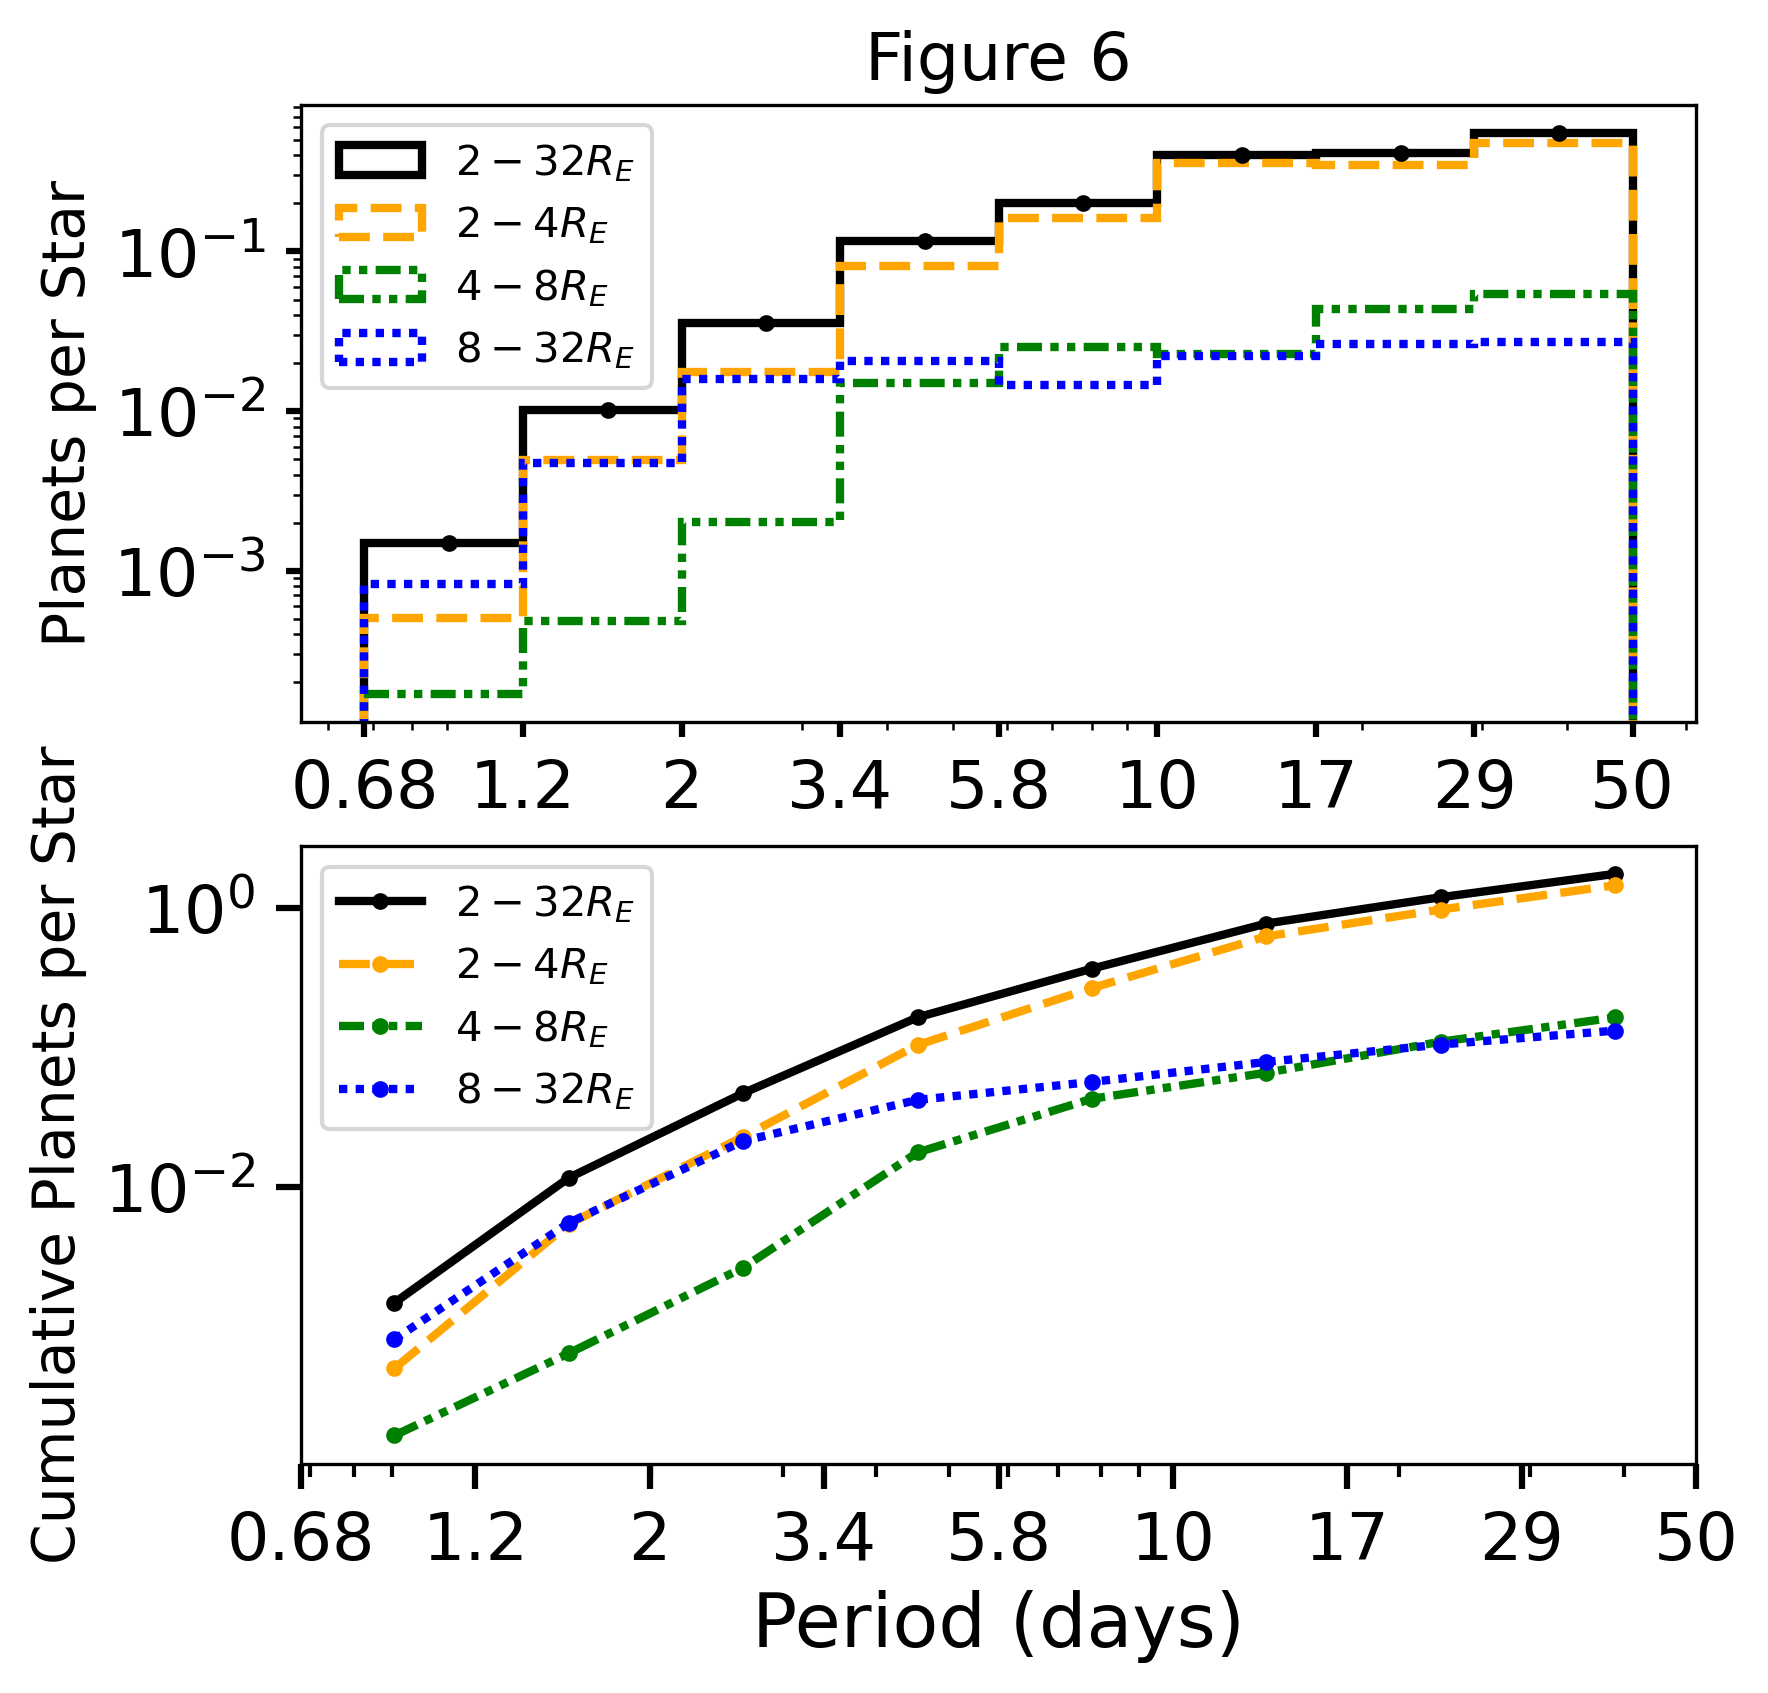

In [244]:
# Fig 7: # planets per star line with power law fit vs period 
def fig7():
    fig, ax = plt.subplots(figsize=(6,6))
    plot_pretty()
    ax.set_xscale('log',base=10)
    ax.set_yscale('log',base=10)
    ax.set_xticks(xp)
    ax.set_xticklabels(['0.68','1.2','2','3.4','5.8','10','17','29','50'])
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)
    ax.tick_params(labelsize=14)
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('Planet Occurrence')
    ax.set_title('Figure 7')

    x = xedge[:-1]*(10**0.125)
    r2,r3,r4 = fig6()
    
    params2, cov = scipy.optimize.curve_fit(func2,x,r2)
    ax.scatter(x,r2,c='orange',marker='^')
    ax.plot(x,func2(x,params2[0],params2[1],params2[2]),lw=2,c='orange',label=r'$2-4R_E$',marker='.')
    #ax.axvline(params2[2],c='orange',ls='--',label='cutoff P = {:.2f}'.format(params2[2]))

    params3, cov = scipy.optimize.curve_fit(func2,x,r3)
    ax.plot(x,func2(x,params3[0],params3[1],params3[2]),lw=2,c='g',label=r'$4-8R_E$',marker='.')
    #ax.axvline(params3[2],c='g',ls=(0,(3,1,1,1,1,1)),label='cutoff P = {:.2f}'.format(params3[2]))

    params4, cov = scipy.optimize.curve_fit(func2,x,r4)
    ax.plot(x,func2(x,params4[0],params4[1],params4[2]),lw=2,c='b',label=r'$8-32R_E$',marker='.')
    #ax.axvline(params4[2],c='b',ls=(0,(1,1)),label='cutoff P = {:.2f}'.format(params4[2]))

    print(params2,params3,params4)
    ax.scatter(x,r3,c='g',marker='^')
    ax.scatter(x,r4,c='b',marker='^')
    ax.legend(fontsize=8)
    
fig7()